https://www.bcb.gov.br/publicacoes/atascopom

In [1]:
## pdf da ultima ata do copom

from langchain_community.document_loaders import PyPDFLoader 
import requests

ultima_ata = requests.get(
  "https://www.bcb.gov.br/api/servico/sitebcb/copom/atas?quantidade=1"
  ).json()
no_reuniao = str(ultima_ata["conteudo"][0]["nroReuniao"])
data_refer = str(ultima_ata["conteudo"][0]["dataReferencia"]).replace("-", "")

url_ata = f"https://www.bcb.gov.br/content/copom/atascopom/Copom{no_reuniao}-not{data_refer+no_reuniao}.pdf"

pdf = PyPDFLoader(url_ata)
ata = pdf.load_and_split()

url_ata

'https://www.bcb.gov.br/content/copom/atascopom/Copom264-not20240731264.pdf'

In [2]:
#  modelo LLM e prompts para o Gemini

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate

import os
os.environ["GOOGLE_API_KEY"] = str(open("passgooglestudio.txt",'r').read())

llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0)

doc_prompt = PromptTemplate.from_template("{page_content}") # extrai texto do PDF
llm_prompt = PromptTemplate.from_template("""
Você é PhD em economia, economista chefe com muita experiência em análise de política monetária, tendo
trabalhado em fundos de investimentos e grandes bancos.

Sua tarefa é ler a ata a seguir da Reunião do Comitê de Política Monetária (Copom)
do Banco Central do Brasil e 
                                          
1. classificar o documento em hawkish ou dovish
2. resumir a a conjuntura econômica
3. destacar os maiores riscos detectados 
4. destacar a decisão do comitê                                          

"{ata}"

Classificação:""")


In [3]:
from langchain.schema.prompt_template import format_document
from langchain.schema import StrOutputParser

# Pipeline de processamento
classificador = (
    {"ata": lambda ata: "\n\n".join(format_document(pagina, doc_prompt) for pagina in ata)}
    | llm_prompt
    | llm
    | StrOutputParser()
)
print(classificador.invoke(ata))

Hawkish

Resumo da conjuntura econômica:

* Ambiente externo adverso com incertezas sobre a flexibilização da política monetária nos EUA e dinâmicas de atividade e inflação em diversos países.
* Bancos centrais das principais economias permanecem determinados a promover a convergência das taxas de inflação para suas metas.
* No cenário doméstico, a atividade econômica e o mercado de trabalho apresentam dinamismo maior do que o esperado.
* A desinflação medida pelo IPCA cheio tem arrefecido, enquanto as medidas de inflação subjacente estão acima da meta.
* As expectativas de inflação para 2024 e 2025 estão em torno de 4,1% e 4,0%, respectivamente.

Maiores riscos detectados:

* Desancoragem das expectativas de inflação por período mais prolongado.
* Maior resiliência na inflação de serviços do que a projetada.
* Conjunção de políticas econômicas externa e interna com impacto inflacionário.
* Desaceleração da atividade econômica global mais acentuada do que a projetada.
* Impactos do ape

Historico

In [4]:
# quantidade de ultimas reuniões para analisar
quantidade = 20
reunioes = list(range(int(no_reuniao) - quantidade, int(no_reuniao) + 1))

In [5]:
## reune o resumo das atas de cadareuniao

from langchain_community.document_loaders import WebBaseLoader
from langchain.docstore.document import Document
import json

documentos = []
for num in reunioes:
    url = f'https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao='
    ata = WebBaseLoader(f"{url}{num}").load()
    conteudo = json.loads(ata[0].page_content)["conteudo"][0]['textoAta']
    dia_ref = json.loads(ata[0].page_content)["conteudo"][0]["dataReferencia"]
    documentos.append(Document(page_content = conteudo, metadata = {"data": dia_ref}))

documentos[1:3]

[Document(page_content='A) Atualização da conjuntura econômica e do cenário do Copom11. No cenário externo, o ambiente se deteriorou substancialmente. O conflito entre Rússia e Ucrânia levou a um aperto significativo das condições financeiras e aumento da incerteza em torno do cenário econômico mundial. Em particular, o choque de oferta decorrente do conflito tem o potencial de exacerbar as pressões inflacionárias que já vinham se acumulando tanto em economias emergentes quanto avançadas. Desde a última reunião, a maioria das commodities teve avanços relevantes em seus preços, em particular as energéticas.2. A reorganização das cadeias de produção globais, com a criação de redundâncias na produção e no suprimento de insumos e mudança no tratamento dos estoques de bens (no sentido de se deter maiores estoques), ganhou novo impulso com o conflito na Europa e as sanções aplicadas à Rússia. Na visão do Comitê, esses desenvolvimentos podem ter consequências de longo prazo e se traduzir em p

In [11]:
## novo promp para o Gemini

llm_prompt = PromptTemplate.from_template("""
Você é um cientista de dados experiente que domina as técnicas de Machine Learning e de Natural Processing Language.
                                          
Sua tarefa é analisar o sentimento dos textos a seguir. Retornar o sentimento do texto em um índice 
que varia de 0 a 100, sendo 0 o sentimento mais negativo, 100 o sentimento mais positivo, 
e 50 o sentimento neutro:

"{documentos}"

Índice:""")


In [12]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain

quantificador = StuffDocumentsChain(llm_chain = LLMChain(llm = llm, prompt = llm_prompt),
                                    document_variable_name = "documentos")


In [13]:
from time import sleep

sentimento = []
for doc in documentos:
    sentimento.append([quantificador.invoke(input = [doc], return_only_outputs = True)["output_text"],
                       doc.metadata["data"]])
    sleep(10)
    

In [14]:
sentimento

[['50', '2022-02-02'],
 ['50', '2022-03-16'],
 ['50', '2022-05-04'],
 ['50', '2022-06-15'],
 ['50', '2022-08-03'],
 ['50', '2022-09-21'],
 ['50', '2022-10-26'],
 ['50', '2022-12-07'],
 ['50', '2023-02-01'],
 ['50', '2023-03-22'],
 ['55', '2023-05-03'],
 ['50', '2023-06-21'],
 ['75', '2023-08-02'],
 ['75', '2023-09-20'],
 ['75', '2023-11-01'],
 ['75', '2023-12-13'],
 ['75', '2024-01-31'],
 ['70', '2024-03-20'],
 ['70', '2024-05-08'],
 ['50', '2024-06-19'],
 ['50', '2024-07-31']]

In [15]:
import pandas as pd

tabela = pd.DataFrame()
tabela['data'] = pd.to_datetime([sublista[1] for sublista in sentimento])
tabela['sentimento'] = [sublista[0] for sublista in sentimento]
tabela['sentimento'] = tabela['sentimento'].astype(int)
tabela

,data,sentimento
0,2022-02-02,50
1,2022-03-16,50
2,2022-05-04,50
3,2022-06-15,50
4,2022-08-03,50
5,2022-09-21,50
6,2022-10-26,50
7,2022-12-07,50
8,2023-02-01,50
9,2023-03-22,50


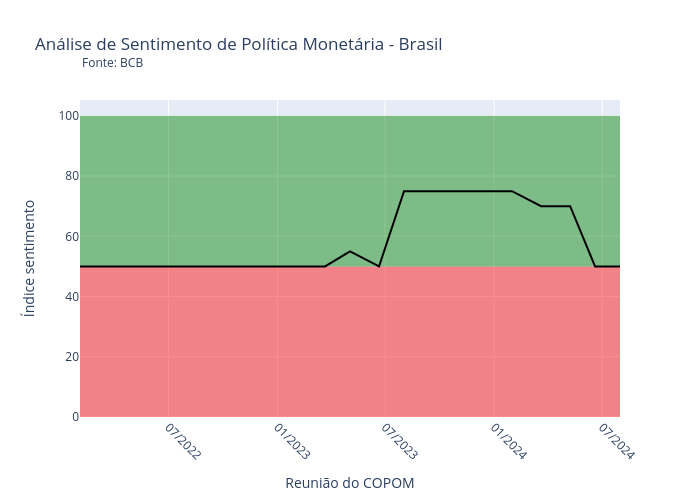

In [16]:
import plotly.graph_objects as go


linha_sentimento = go.Scatter(x=tabela['data'],y=tabela['sentimento'],mode='lines',line_color='black',name='Sentimento',showlegend=False)
# Criar as áreas de fundo
area_negativa = go.Scatter(
    x=tabela['data'],
    y=[50] * len(tabela),  # Linha horizontal em y=50
    mode='lines',
    line=dict(width=0, color='red'), # Linha invisível
    fill='tonexty', # Preencher até a próxima linha
    fillcolor='rgba(255, 0, 0, 0.45)',  # Vermelho com transparência
    showlegend=False
)

area_positiva = go.Scatter(
    x=tabela['data'],
    y=[100] * len(tabela), # Linha horizontal em y=100
    mode='lines',
    line=dict(width=0, color='green'), # Linha invisível
    fill='tonexty', # Preencher até a próxima linha
    fillcolor='rgba(0, 128, 0, 0.45)',  # Verde com transparência
    showlegend=False
)

# Criar o objeto figura e adicionar os traços
fig = go.Figure(data=[area_negativa, area_positiva, linha_sentimento])

# Personalizar o layout
fig.update_layout(
    title="Análise de Sentimento de Política Monetária - Brasil",
    xaxis_title="Reunião do COPOM",
    yaxis_title="Índice sentimento",
    xaxis_tickformat="%m/%Y",
    xaxis_tickangle=45,
    
    # Adicionar nota como anotação
    annotations=[dict(
        x=0, 
        y=1.15, 
        xref="paper", 
        yref="paper", 
        text="Fonte: BCB",
        showarrow=False
    )]
)


fig.show("png")  # para github
# fig.show()       # Grafico interativo